# Module import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings(action='ignore')

# Data Load

In [ ]:
BATCH_SIZE = 128
EPOCHS = 15

# transform
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) 
                                                                                 
# Datasets
train_set = dsets.FashionMNIST(root='MNIST_data/',
                          train=True,
                          transform=transform,
                          download=True)

test_set = dsets.FashionMNIST(root='MNIST_data/',
                         train=False,
                         transform=transform,
                         download=True)


In [3]:
print(f"shape of train data : {train_set.data.shape}")
print(f"label kinds : {train_set.targets.unique()}")

# train data
X = train_set.data.type(torch.float32).numpy()
y = train_set.targets

# test data
X_test = test_set.data.type(torch.float32).numpy()

shape of train data : torch.Size([60000, 28, 28])
label kinds : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


In [6]:
def mnist_imshow(size=1, start=0, x = X, train = True):
    plt.figure(figsize = (20*size, size))
    for idx in range(start, start+20):
        plt.subplot(start+1, start+20, idx + 1)
        plt.axis('off')
        plt.imshow(x[idx], cmap = 'gray_r')
        if train:
            plt.title(f"Class : {y[idx]}")

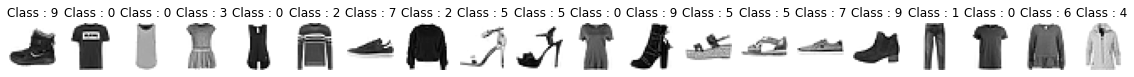

In [7]:
mnist_imshow(x = X, train=True)

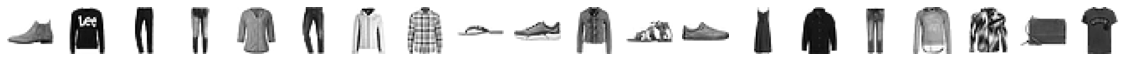

In [8]:
mnist_imshow(x = X_test, train=False)

# Train Test Split

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 16, stratify = y, shuffle = True)

print(f"X_train's shape : {X_train.shape}")

X_train's shape : (48000, 28, 28)


# 환경 설정

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [11]:
BATCH_SIZE = 128
EPOCHS = 15

In [12]:
class DataSet(Dataset):
  def __init__(self, image, label = None):
    super(DataSet, self).__init__()
    self._image = image
    self._label = label

  def __len__(self):
    return len(self._image)

  def __getitem__(self, idx):
    if self._label is None:
      image = self._image[idx]
      return image

    else:
      image = self._image[idx]
      label = self._label[idx]

      return image, label

In [19]:
## Normalization
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

In [20]:
train_dataset = DataSet(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

val_dataset = DataSet(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = False)

test_dataset = DataSet(X_test)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = False, drop_last = False)

# train function

In [30]:
def train(model, train_loader):
  model.train() # 학습
  train_loss = 0 # train loss 측정 초기화
  correct = 0 # 정확도 측정 초기화

  for image, label in train_loader:
    image = image.to(DEVICE) # 학습 데이터 DEVICE환경으로 보내기
    label = label.to(DEVICE)
    optimizer.zero_grad() # 순전파 전에 누적된 gradient를 지움
    output = model(image) # 순전파 계산
    loss = criterion(output, label) # 손실함수 계산
    loss.backward() # 역전파 계산
    optimizer.step() # 가중치 update

    train_loss += loss.item() # loss값 반영
    prediction = output.max(1, keepdim = True)[1] # output 중 axis=1 방향으로 max값을 탐색
    correct += prediction.eq(label.view_as(prediction)).sum().item() # 예측값과 정답이 일치하면 correct 증가
      
  train_loss /= len(train_loader) # 최종 손실함수 
  train_accuracy = 100. * correct / len(train_loader.dataset) # 정확도
  return train_loss, train_accuracy

In [25]:
def evaluate(model, test_loader):
  model.eval() # 평가
  test_loss = 0 # test loss 값 초기화
  correct = 0 # 정확도 측정 초기화

  with torch.no_grad(): # 평가 하는 동안에는 gradient계산 X
    for image, label in test_loader:
      image = image.to(DEVICE)
      label = label.to(DEVICE)
      output = model(image)
      test_loss += criterion(output, label).item() 
      prediction = output.max(1, keepdim = True)[1] 
      correct += prediction.eq(label.view_as(prediction)).sum().item()

  test_loss /= len(test_loader)
  test_accuracy = 100. * correct / len(test_loader.dataset)
  return test_loss, test_accuracy

In [ ]:
def pred(model, test_loader):
  model.eval()
  pred_li = []

  with torch.no_grad():
    for image in test_loader:
      image = image.to(DEVICE)
      output = model(image)
      pred_li.append(output.cpu().numpy().argmax(axis=1))

  return np.concatenate(pred_li)

# Model

In [26]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.linear1 = nn.Sequential(
        nn.Linear(28 * 28, 512),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.BatchNorm1d(512)
    )
    self.linear2 = nn.Sequential(
        nn.Linear(512, 256),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.BatchNorm1d(256)
    )
    self.linear3 = nn.Sequential(
        nn.Linear(256, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(0.5),
        nn.BatchNorm1d(128)        
    )
    self.linear4 = nn.Sequential(
        nn.Linear(128, 10)
    )

  def forward(self, x):
    x = x.view(-1, 28 * 28)
    x = self.linear1(x)
    x = self.linear2(x)
    x = self.linear3(x)
    x = self.linear4(x)
    return x

In [28]:
model = Net().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.01, momentum = 0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

print(model)

Net(
  (linear1): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear2): Sequential(
    (0): Linear(in_features=512, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear3): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear4): Sequential(
    (0): Linear(in_features=128, out_features=10, bias=True)
  )
)


# Experiment

## Original

=> Val Accuracy: 85.08 % 


## Experiment

conv filter 는 사용하지 않고 진행하겠습니다.

- **Add ReLU**

=> Val Accuracy: 85.60 % 
    
    약간의 차이긴 하지만 성능이 0.5정도 올라갔음.

- **add ReLU, Dropout**

=> Val Accuracy: 84.62 % 

    오히려 성능이 떨어짐

- **Add ReLU, BatchNormalization

=> Val Accuracy: 89.29 % 

    확실히 BatchNormalization 층을 더했을 때 좋은 성능을 보이는 것이 확인됨

- **Add ReLU, BatchNormalization, dropout**

=> Val Accuracy: 86.91 % 

    오히려 dropout층을 추가했을 때 성능이 떨어짐. 아무래도 층이 복잡한 것도 아니고 깊은 것도 아니여서 dropout층을 하여 노드 수를 줄이는게 좋은 선택이 아닌 것으로 보임.





In [31]:
result_list = []
for epoch in range(1, EPOCHS + 1):
  train_loss, train_accuracy = train(model, train_loader)
  val_loss, val_accuracy = evaluate(model, val_loader)
  print(f"[EPOCH: {epoch}], \tTrain Loss: {train_loss:.4f}, \tTrain Accuracy: {train_accuracy:.2f} %, \tVal Loss: {val_loss:.4f}, \tVal Accuracy: {val_accuracy:.2f} % \n")
  result = {
    'EPOCH': epoch,
    'Train Loss': train_loss,
    'Train Accuracy': train_accuracy,
    'Val Loss': val_loss,
    'Val Accuracy': val_accuracy}
  
  result_list.append(result)
result_df = pd.DataFrame(result_list)

[EPOCH: 1], 	Train Loss: 1.0874, 	Train Accuracy: 64.29 %, 	Val Loss: 0.5701, 	Val Accuracy: 79.97 % 

[EPOCH: 2], 	Train Loss: 0.6701, 	Train Accuracy: 77.14 %, 	Val Loss: 0.4731, 	Val Accuracy: 82.86 % 

[EPOCH: 3], 	Train Loss: 0.5960, 	Train Accuracy: 79.51 %, 	Val Loss: 0.4392, 	Val Accuracy: 84.28 % 

[EPOCH: 4], 	Train Loss: 0.5587, 	Train Accuracy: 80.90 %, 	Val Loss: 0.4086, 	Val Accuracy: 85.12 % 

[EPOCH: 5], 	Train Loss: 0.5326, 	Train Accuracy: 81.63 %, 	Val Loss: 0.3950, 	Val Accuracy: 85.53 % 

[EPOCH: 6], 	Train Loss: 0.5103, 	Train Accuracy: 82.53 %, 	Val Loss: 0.3815, 	Val Accuracy: 86.21 % 

[EPOCH: 7], 	Train Loss: 0.5055, 	Train Accuracy: 82.61 %, 	Val Loss: 0.3853, 	Val Accuracy: 85.53 % 

[EPOCH: 8], 	Train Loss: 0.4940, 	Train Accuracy: 82.75 %, 	Val Loss: 0.3788, 	Val Accuracy: 86.12 % 

[EPOCH: 9], 	Train Loss: 0.4845, 	Train Accuracy: 83.25 %, 	Val Loss: 0.3745, 	Val Accuracy: 85.96 % 

[EPOCH: 10], 	Train Loss: 0.4773, 	Train Accuracy: 83.37 %, 	Val Loss: 0.

(15,)


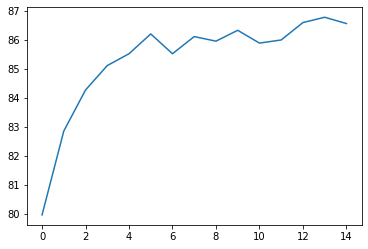

In [117]:
loss = result_df['Val Accuracy'].values

plt.plot(range(len(loss)), loss)